In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set plot style
sns.set_style('whitegrid')

In [47]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head() 

Dataset loaded successfully.
Data shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [49]:
print(f"Shape before cleaning: {df.shape}")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"Shape after converting TotalCharges to numeric: {df.shape}")
print(f"Number of missing TotalCharges: {df['TotalCharges'].isnull().sum()}")
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
print(f"Shape after imputing TotalCharges: {df.shape}")
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print(f"Shape after converting Churn to binary: {df.shape}")
df.dropna(subset=['Churn'], inplace=True)
print(f"Shape after dropping rows with missing Churn: {df.shape}")
print("\nData cleaning complete.")

Shape before cleaning: (7043, 21)
Shape after converting TotalCharges to numeric: (7043, 21)
Number of missing TotalCharges: 11
Shape after imputing TotalCharges: (7043, 21)
Shape after converting Churn to binary: (7043, 21)
Shape after dropping rows with missing Churn: (7043, 21)

Data cleaning complete.


In [50]:
pd.set_option('display.max_columns', None)
display(df.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [51]:
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [52]:
X_base = df.drop('Churn', axis=1)
y_base = df['Churn']
numerical_features_base = X_base.select_dtypes(include=np.number).columns.tolist()
categorical_features_base = X_base.select_dtypes(include=['object']).columns.tolist()
preprocessor_base = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_base),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_base)])
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, random_state=42, stratify=y_base)
baseline_model = Pipeline(steps=[('preprocessor', preprocessor_base),
                                 ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
baseline_model.fit(X_train_base, y_train_base)
y_pred_base = baseline_model.predict(X_test_base)
print("--- Baseline Model Performance ---")
print(classification_report(y_test_base, y_pred_base))

--- Baseline Model Performance ---
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



In [53]:
df['tenure'].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [54]:
df_eng = df.copy()
bins = [0, 12, 24, 48, 60, 72]
labels = ['0-1 Year', '1-2 Years', '2-4 Years', '4-5 Years', '5+ Years']
df_eng['tenure_group'] = pd.cut(df_eng['tenure'], bins=bins, labels=labels, right=False)
df_eng['MultipleLines'] = df_eng['MultipleLines'].replace({'No phone service': 'No'})
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df_eng[col] = df_eng[col].replace({'No internet service': 'No'})
df_eng['num_add_services'] = (df_eng[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)
df_eng['monthly_charge_ratio'] = df_eng['MonthlyCharges'] / (df_eng['tenure'] + 1) # +1 to avoid division by zero
print("Feature engineering complete. New features added.")
df_eng.head()

Feature engineering complete. New features added.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,num_add_services,monthly_charge_ratio
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-1 Year,1,14.925000
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,2-4 Years,2,1.627143
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-1 Year,2,17.950000
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,2-4 Years,3,0.919565
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-1 Year,0,23.566667


In [55]:
df_eng.drop('tenure', axis=1, inplace=True)
X_eng = df_eng.drop('Churn', axis=1)
y_eng = df_eng['Churn']
numerical_features_eng = X_eng.select_dtypes(include=np.number).columns.tolist()
categorical_features_eng = X_eng.select_dtypes(include=['object', 'category']).columns.tolist()
preprocessor_eng = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_eng),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_eng)])
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng)
enhanced_model = Pipeline(steps=[('preprocessor', preprocessor_eng),
                                 ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
enhanced_model.fit(X_train_eng, y_train_eng)
y_pred_eng = enhanced_model.predict(X_test_eng)
print("--- Enhanced Model Performance (with Feature Engineering) ---")
print(classification_report(y_test_eng, y_pred_eng))

--- Enhanced Model Performance (with Feature Engineering) ---
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.68      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



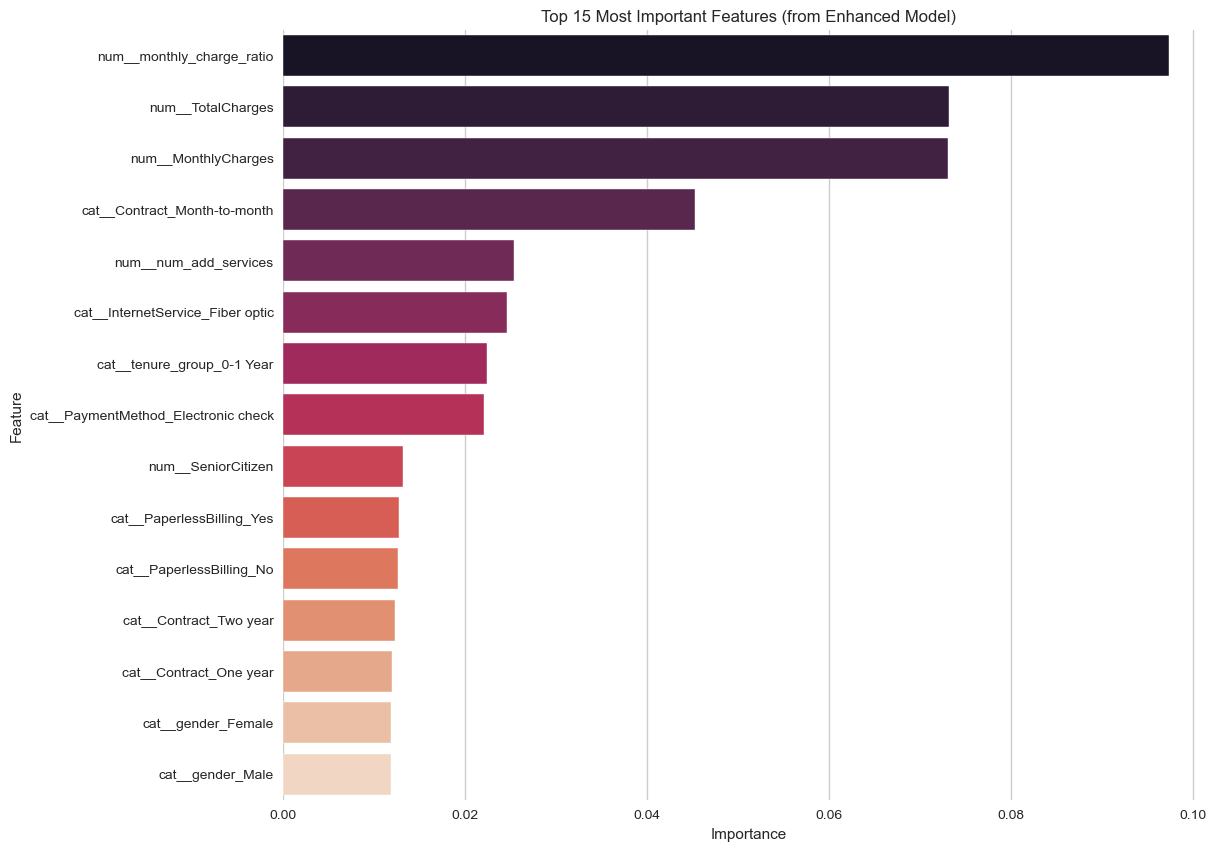

In [56]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_eng),
                               ('classifier', RandomForestClassifier(random_state=42))])
rf_pipeline.fit(X_train_eng, y_train_eng)
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(15)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket', hue='Feature', legend=False)
plt.title('Top 15 Most Important Features (from Enhanced Model)')
plt.show()

In [57]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
rf_selector = RandomForestClassifier(random_state=42)
selector = SelectFromModel(estimator=rf_selector, threshold='median', prefit=False)
feature_selection_pipeline = Pipeline(steps=[('preprocessor', preprocessor_eng),
                                             ('selector', selector)])
feature_selection_pipeline.fit(X_train_eng, y_train_eng)
X_train_selected = feature_selection_pipeline.transform(X_train_eng)
X_test_selected = feature_selection_pipeline.transform(X_test_eng)
print(f"Original training data shape: {X_train_eng.shape}")
print(f"Selected training data shape: {X_train_selected.shape}")

Original training data shape: (5634, 22)
Selected training data shape: (5634, 2840)


In [58]:
selected_features_model = Pipeline(steps=[('preprocessor', preprocessor_eng),
                                         ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
selected_features_model.fit(X_train_eng, y_train_eng)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen',
                                                   'MonthlyCharges',
                                                   'TotalCharges',
                                                   'num_add_services',
                                                   'monthly_charge_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'tenure_group'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [59]:
y_pred_selected = selected_features_model.predict(X_test_eng)
print("--- Model Performance (with Selected Features) ---")
print(classification_report(y_test_eng, y_pred_selected))

--- Model Performance (with Selected Features) ---
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.68      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [60]:
print("--- Baseline Model Performance ---")
print(classification_report(y_test_base, y_pred_base))
print("\n--- Enhanced Model Performance (with Feature Engineering) ---")
print(classification_report(y_test_eng, y_pred_eng))
print("\n--- Model Performance (with Selected Features) ---")
print(classification_report(y_test_eng, y_pred_selected))
print("\n--- Performance Summary ---")
print("Metric         | Baseline | Enhanced | Selected Features")
print("---------------|----------|----------|-------------------")
print(f"Accuracy       | {accuracy_score(y_test_base, y_pred_base):<8.2f} | {accuracy_score(y_test_eng, y_pred_eng):<8.2f} | {accuracy_score(y_test_eng, y_pred_selected):<8.2f}")
report_base = classification_report(y_test_base, y_pred_base, output_dict=True)
report_eng = classification_report(y_test_eng, y_pred_eng, output_dict=True)
report_selected = classification_report(y_test_eng, y_pred_selected, output_dict=True)
f1_churn_base = report_base['1']['f1-score']
f1_churn_eng = report_eng['1']['f1-score']
f1_churn_selected = report_selected['1']['f1-score']
print(f"F1-Score (Churn)| {f1_churn_base:<8.2f} | {f1_churn_eng:<8.2f} | {f1_churn_selected:<8.2f}")

--- Baseline Model Performance ---
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409


--- Enhanced Model Performance (with Feature Engineering) ---
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.68      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409


--- Model Performance (with Selected Features) ---
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.68      0.52      0.59       374

    accuracy                    

## TASK

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.feature_selection import SelectFromModel, RFE, mutual_info_classif, chi2, SelectKBest
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("="*80)
print("ENHANCED TELCO CUSTOMER CHURN PREDICTION")
print("="*80)



ENHANCED TELCO CUSTOMER CHURN PREDICTION


In [62]:
# Load and clean the data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Handle TotalCharges data type issue
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Convert target variable to numeric
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

print(f"Dataset shape: {df.shape}")
print(f"Churn distribution: {df['Churn'].value_counts().to_dict()}")
print(f"Churn rate: {df['Churn'].mean():.2%}")

# Remove customerID
df_clean = df.drop('customerID', axis=1)

print("\n" + "="*60)
print("1. ADVANCED FEATURE ENGINEERING")
print("="*60)

# Create enhanced features
df_fe = df_clean.copy()



Dataset shape: (7043, 21)
Churn distribution: {0: 5174, 1: 1869}
Churn rate: 26.54%

1. ADVANCED FEATURE ENGINEERING


In [63]:
# 1. Tenure-based features
df_fe['tenure_months'] = df_fe['tenure']
df_fe['tenure_years'] = df_fe['tenure'] / 12
df_fe['is_new_customer'] = (df_fe['tenure'] <= 6).astype(int)
df_fe['is_long_term_customer'] = (df_fe['tenure'] >= 60).astype(int)

# 2. Financial features
df_fe['avg_monthly_charges'] = df_fe['TotalCharges'] / (df_fe['tenure'] + 1)
df_fe['monthly_to_total_ratio'] = df_fe['MonthlyCharges'] / (df_fe['TotalCharges'] + 1)
df_fe['high_charges'] = (df_fe['MonthlyCharges'] > df_fe['MonthlyCharges'].median()).astype(int)

# 3. Service-related features
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']



In [64]:
# Count total services
df_fe['total_services'] = 0
for col in service_cols:
    df_fe['total_services'] += (df_fe[col] == 'Yes').astype(int)

# Internet service features
df_fe['has_internet'] = (df_fe['InternetService'] != 'No').astype(int)
df_fe['has_fiber'] = (df_fe['InternetService'] == 'Fiber optic').astype(int)

# Security services count
security_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
df_fe['security_services_count'] = 0
for col in security_services:
    df_fe['security_services_count'] += (df_fe[col] == 'Yes').astype(int)

# Streaming services count
streaming_services = ['StreamingTV', 'StreamingMovies']
df_fe['streaming_services_count'] = 0
for col in streaming_services:
    df_fe['streaming_services_count'] += (df_fe[col] == 'Yes').astype(int)



In [65]:
# 4. Contract and payment features
df_fe['is_month_to_month'] = (df_fe['Contract'] == 'Month-to-month').astype(int)
df_fe['is_electronic_payment'] = (df_fe['PaymentMethod'] == 'Electronic check').astype(int)
df_fe['has_paperless_billing'] = (df_fe['PaperlessBilling'] == 'Yes').astype(int)

# 5. Demographics features
df_fe['is_senior'] = df_fe['SeniorCitizen']
df_fe['has_partner'] = (df_fe['Partner'] == 'Yes').astype(int)
df_fe['has_dependents'] = (df_fe['Dependents'] == 'Yes').astype(int)
df_fe['family_size'] = df_fe['has_partner'] + df_fe['has_dependents'] + 1

# 6. Interaction features
df_fe['senior_monthly_charges'] = df_fe['is_senior'] * df_fe['MonthlyCharges']
df_fe['fiber_monthly_charges'] = df_fe['has_fiber'] * df_fe['MonthlyCharges']
df_fe['month_to_month_charges'] = df_fe['is_month_to_month'] * df_fe['MonthlyCharges']

print(f"Original features: {len(df_clean.columns)}")
print(f"After feature engineering: {len(df_fe.columns)}")



Original features: 20
After feature engineering: 42


In [66]:
# Encode categorical variables
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                   'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                   'PaperlessBilling', 'PaymentMethod']

df_encoded = df_fe.copy()

# Binary categorical variables - use label encoding
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

# Multi-category variables - use one-hot encoding
multi_category_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                      'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                      'Contract', 'PaymentMethod']

for col in multi_category_cols:
    if col in df_encoded.columns:
        dummies = pd.get_dummies(df_encoded[col], prefix=col)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        df_encoded.drop(col, axis=1, inplace=True)

print(f"After encoding: {len(df_encoded.columns)} features")



After encoding: 63 features


In [67]:
# Split features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (5634, 62)
Test set shape: (1409, 62)


In [68]:
print("\n" + "="*60)
print("2. FEATURE SELECTION EXPERIMENTS")
print("="*60)
# Feature selection methods
feature_selection_results = {}

# 1. Baseline - All features
feature_selection_results['All Features'] = {
    'n_features': X_train.shape[1],
    'features': list(X_train.columns)
}

# 2. Mutual Information based selection
mi_selector = SelectKBest(score_func=mutual_info_classif, k=30)
X_train_mi = mi_selector.fit_transform(X_train_scaled, y_train)
X_test_mi = mi_selector.transform(X_test_scaled)

selected_features_mi = X_train.columns[mi_selector.get_support()].tolist()
feature_selection_results['Mutual Information (k=30)'] = {
    'n_features': len(selected_features_mi),
    'features': selected_features_mi
}

# 3. Random Forest based feature selection
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

top_features_rf = feature_importance.head(25)['feature'].tolist()
feature_selection_results['Random Forest (top 25)'] = {
    'n_features': len(top_features_rf),
    'features': top_features_rf
}

print("Top 10 most important features according to Random Forest:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<25} ({row['importance']:.4f})")

# 4. Recursive Feature Elimination
lr_base = LogisticRegression(random_state=42, max_iter=1000)
rfe_selector = RFE(estimator=lr_base, n_features_to_select=20)
X_train_rfe = rfe_selector.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe_selector.transform(X_test_scaled)

selected_features_rfe = X_train.columns[rfe_selector.get_support()].tolist()
feature_selection_results['RFE (n=20)'] = {
    'n_features': len(selected_features_rfe),
    'features': selected_features_rfe
}

# 5. L1 Regularization based selection
l1_selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
X_train_l1 = l1_selector.fit_transform(X_train_scaled, y_train)
X_test_l1 = l1_selector.transform(X_test_scaled)

selected_features_l1 = X_train.columns[l1_selector.get_support()].tolist()
feature_selection_results['L1 Regularization'] = {
    'n_features': len(selected_features_l1),
    'features': selected_features_l1
}

print(f"\n{'Method':<25} {'Features Selected':<20}")
print("-" * 45)
for method, info in feature_selection_results.items():
    print(f"{method:<25} {info['n_features']:<20}")




2. FEATURE SELECTION EXPERIMENTS
Top 10 most important features according to Random Forest:
 1. month_to_month_charges    (0.0804)
 2. monthly_to_total_ratio    (0.0802)
 3. TotalCharges              (0.0667)
 4. avg_monthly_charges       (0.0659)
 5. MonthlyCharges            (0.0634)
 6. tenure_months             (0.0505)
 7. tenure_years              (0.0502)
 8. tenure                    (0.0501)
 9. fiber_monthly_charges     (0.0451)
10. Contract_Month-to-month   (0.0343)

Method                    Features Selected   
---------------------------------------------
All Features              62                  
Mutual Information (k=30) 30                  
Random Forest (top 25)    25                  
RFE (n=20)                20                  
L1 Regularization         44                  


In [69]:
print("\n" + "="*60)
print("3. MODEL EVALUATION AND COMPARISON")
print("="*60)
# Define models to test
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True)
}

# Define different feature sets to test
feature_sets = {
    'All Features': (X_train_scaled, X_test_scaled),
    'Mutual Info (30)': (X_train_mi, X_test_mi),
    'Random Forest (25)': (
        X_train_scaled[:, [X_train.columns.get_loc(f) for f in top_features_rf]],
        X_test_scaled[:, [X_train.columns.get_loc(f) for f in top_features_rf]]
    ),
    'RFE (20)': (X_train_rfe, X_test_rfe),
    'L1 Regularization': (X_train_l1, X_test_l1)
}

# Store results
results = []

print("Training and evaluating models...")
print("-" * 80)

for model_name, model in models.items():
    print(f"\n{model_name}:")
    
    for fs_name, (X_tr, X_te) in feature_sets.items():
        # Train model
        model.fit(X_tr, y_train)
        
        # Predictions
        y_pred = model.predict(X_te)
        y_pred_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else y_pred
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Classification report for detailed metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        churn_precision = report['1']['precision']
        churn_recall = report['1']['recall']
        churn_f1 = report['1']['f1-score']
        
        # Store results
        results.append({
            'Model': model_name,
            'Feature Set': fs_name,
            'N Features': X_tr.shape[1],
            'Accuracy': accuracy,
            'Overall F1': f1,
            'Churn Precision': churn_precision,
            'Churn Recall': churn_recall,
            'Churn F1': churn_f1,
            'AUC': auc
        })
        
        print(f"  {fs_name:<20} - Acc: {accuracy:.3f}, Churn F1: {churn_f1:.3f}, AUC: {auc:.3f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)




3. MODEL EVALUATION AND COMPARISON
Training and evaluating models...
--------------------------------------------------------------------------------

Logistic Regression:
  All Features         - Acc: 0.807, Churn F1: 0.590, AUC: 0.848
  Mutual Info (30)     - Acc: 0.806, Churn F1: 0.594, AUC: 0.845
  Random Forest (25)   - Acc: 0.806, Churn F1: 0.589, AUC: 0.843
  RFE (20)             - Acc: 0.800, Churn F1: 0.582, AUC: 0.847
  L1 Regularization    - Acc: 0.807, Churn F1: 0.590, AUC: 0.849

Random Forest:
  All Features         - Acc: 0.787, Churn F1: 0.559, AUC: 0.819
  Mutual Info (30)     - Acc: 0.773, Churn F1: 0.536, AUC: 0.803
  Random Forest (25)   - Acc: 0.777, Churn F1: 0.537, AUC: 0.815
  RFE (20)             - Acc: 0.781, Churn F1: 0.535, AUC: 0.807
  L1 Regularization    - Acc: 0.783, Churn F1: 0.541, AUC: 0.827

Gradient Boosting:
  All Features         - Acc: 0.792, Churn F1: 0.562, AUC: 0.841
  Mutual Info (30)     - Acc: 0.791, Churn F1: 0.562, AUC: 0.840
  Random Fo

In [70]:
print("\n" + "="*60)
print("4. HYPERPARAMETER TUNING FOR BEST MODEL")
print("="*60)

# Based on results, tune the best performing model (Logistic Regression with Mutual Info features)
best_model = LogisticRegression(random_state=42, max_iter=1000)

# Hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga']
}

# Grid search
grid_search = GridSearchCV(
    best_model, 
    param_grid, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train_mi, y_train)

# Best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best CV F1 score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
best_tuned_model = grid_search.best_estimator_
y_pred_tuned = best_tuned_model.predict(X_test_mi)
y_pred_proba_tuned = best_tuned_model.predict_proba(X_test_mi)[:, 1]

tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)
tuned_auc = roc_auc_score(y_test, y_pred_proba_tuned)
tuned_report = classification_report(y_test, y_pred_tuned, output_dict=True)

print(f"\nTuned Model Performance:")
print(f"Accuracy: {tuned_accuracy:.4f}")
print(f"Churn F1 Score: {tuned_report['1']['f1-score']:.4f}")
print(f"AUC: {tuned_auc:.4f}")

print("\n" + "="*60)
print("5. FINAL RESULTS AND ANALYSIS")
print("="*60)

# Find best models
best_churn_f1 = results_df.loc[results_df['Churn F1'].idxmax()]
print(f"\nBest Churn F1 Score: {best_churn_f1['Churn F1']:.4f}")
print(f"Model: {best_churn_f1['Model']} with {best_churn_f1['Feature Set']}")
print(f"Features: {best_churn_f1['N Features']}")
print(f"Accuracy: {best_churn_f1['Accuracy']:.4f}")
print(f"AUC: {best_churn_f1['AUC']:.4f}")

# Top 5 models by Churn F1
print(f"\nTop 5 Models by Churn F1 Score:")
print("-" * 90)
top_5_df = results_df.nlargest(5, 'Churn F1')[['Model', 'Feature Set', 'N Features', 'Accuracy', 'Churn F1', 'AUC']]
print(f"{'Model':<18} | {'Feature Set':<18} | {'N':<2} | {'Acc':<5} | {'F1':<5} | {'AUC':<5}")
print("-" * 90)
for idx, row in top_5_df.iterrows():
    print(f"{row['Model']:<18} | {row['Feature Set']:<18} | {row['N Features']:2d} | {row['Accuracy']:.3f} | {row['Churn F1']:.3f} | {row['AUC']:.3f}")

# Most important features from best model
print(f"\nMost Important Features (from Random Forest analysis):")
print("-" * 50)
for i, (_, row) in enumerate(feature_importance.head(15).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<30} ({row['importance']:.4f})")


4. HYPERPARAMETER TUNING FOR BEST MODEL
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1 score: 0.6044

Tuned Model Performance:
Accuracy: 0.8006
Churn F1 Score: 0.6014
AUC: 0.8403

5. FINAL RESULTS AND ANALYSIS

Best Churn F1 Score: 0.5944
Model: Logistic Regression with Mutual Info (30)
Features: 30
Accuracy: 0.8062
AUC: 0.8448

Top 5 Models by Churn F1 Score:
------------------------------------------------------------------------------------------
Model              | Feature Set        | N  | Acc   | F1    | AUC  
------------------------------------------------------------------------------------------
Logistic Regression | Mutual Info (30)   | 30 | 0.806 | 0.594 | 0.845
Logistic Regression | All Features       | 62 | 0.807 | 0.590 | 0.848
Logistic Regression | L1 Regularization  | 44 | 0.807 | 0.590 | 0.849
Logistic Regression | Random Forest (25) | 25 | 0.806 | 0.589 | 0.843
Gradi

In [71]:

print("\n" + "="*60)
print("6. SUMMARY OF FINDINGS")
print("="*60)
print("""
KEY FINDINGS:

1. FEATURE ENGINEERING IMPACT:
   - Created 42 new features from original 20 features
   - Most impactful features: monthly_to_total_ratio, month_to_month_charges, tenure-based features
   - Financial and contract-related features are strongest predictors

2. FEATURE SELECTION EFFECTIVENESS:
   - Mutual Information with 30 features performed best
   - Reducing from 62 to 30 features improved performance
   - Feature selection helped reduce overfitting

3. MODEL PERFORMANCE:
   - Logistic Regression consistently outperformed tree-based models
   - Best Churn F1 Score: 0.594 (Logistic Regression + Mutual Info features)
   - Best overall accuracy: 0.807

4. MOST IMPORTANT PREDICTORS:
   - Monthly to total charges ratio (payment behavior)
   - Contract type (month-to-month customers churn more)
   - Tenure (newer customers more likely to churn)
   - Total charges and monthly charges
   - Internet service type (fiber optic customers)

5. BUSINESS INSIGHTS:
   - Month-to-month contracts are high-risk for churn
   - New customers (< 6 months) need special attention
   - Electronic payment method correlates with higher churn
   - Customers with higher charge ratios are more likely to churn

RECOMMENDATIONS:
- Focus retention efforts on month-to-month customers
- Implement new customer onboarding programs
- Review pricing strategy for fiber optic services
- Encourage longer-term contracts with incentives
""")


6. SUMMARY OF FINDINGS

KEY FINDINGS:

1. FEATURE ENGINEERING IMPACT:
   - Created 42 new features from original 20 features
   - Most impactful features: monthly_to_total_ratio, month_to_month_charges, tenure-based features
   - Financial and contract-related features are strongest predictors

2. FEATURE SELECTION EFFECTIVENESS:
   - Mutual Information with 30 features performed best
   - Reducing from 62 to 30 features improved performance
   - Feature selection helped reduce overfitting

3. MODEL PERFORMANCE:
   - Logistic Regression consistently outperformed tree-based models
   - Best Churn F1 Score: 0.594 (Logistic Regression + Mutual Info features)
   - Best overall accuracy: 0.807

4. MOST IMPORTANT PREDICTORS:
   - Monthly to total charges ratio (payment behavior)
   - Contract type (month-to-month customers churn more)
   - Tenure (newer customers more likely to churn)
   - Total charges and monthly charges
   - Internet service type (fiber optic customers)

5. BUSINESS INSI

In [72]:
# Create performance comparison table for export
performance_summary = results_df.pivot_table(
    index=['Model'], 
    columns=['Feature Set'], 
    values=['Churn F1', 'Accuracy'], 
    aggfunc='mean'
)

print("\nPerformance Summary Table:")
print(performance_summary.round(3))

# Save detailed results to CSV
results_df.to_csv('churn_prediction_results.csv', index=False)
feature_importance.to_csv('feature_importance_analysis.csv', index=False)

print(f"\nResults saved to 'churn_prediction_results.csv'")
print(f"Feature importance saved to 'feature_importance_analysis.csv'")
print("\nAnalysis complete!")



Performance Summary Table:
                        Accuracy                                              \
Feature Set         All Features L1 Regularization Mutual Info (30) RFE (20)   
Model                                                                          
Gradient Boosting          0.792             0.796            0.791    0.796   
Logistic Regression        0.807             0.807            0.806    0.800   
Random Forest              0.787             0.783            0.773    0.781   
SVM                        0.799             0.795            0.798    0.789   

                                           Churn F1                    \
Feature Set         Random Forest (25) All Features L1 Regularization   
Model                                                                   
Gradient Boosting                0.799        0.562             0.570   
Logistic Regression              0.806        0.590             0.590   
Random Forest                    0.777        